In [1]:
import sys
import os
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt

# Set the base directory 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(base_dir) # to be able to find ./config/myfile.yaml

# Add base directory to the Python path for imports
sys.path.append(base_dir)


In [2]:
%load_ext autoreload
%autoreload 2
from stream_sim import surveys, observed

In [3]:
lsst_dc2 = surveys.Survey.load(survey = 'lsst', release='yr5')

Loading survey data for 'lsst_yr5'...
  Loading config from: lsst_yr5.yaml

LOADING SURVEY DATA FILES
Data directory: /sps/lsst/users/mpelissi/packages/stream_sim/stream_sim/../data/surveys/lsst_yr5

Available bands: g, i, r, u, y, z

Loading magnitude limit maps...
  Loading g-band magnitude limit map...
    File: baseline_v5.0.0_year_5.0_band_g_nside_128.hsp
    Detected sparse HEALPix format (.hsp)
    ✓ Success
  ⚠ Warning: 'maglim_map_i' not specified in config (skipping i-band)
  Loading r-band magnitude limit map...
    File: baseline_v5.0.0_year_5.0_band_r_nside_128.hsp
    Detected sparse HEALPix format (.hsp)
    ✓ Success
  ⚠ Warning: 'maglim_map_u' not specified in config (skipping u-band)
  ⚠ Warning: 'maglim_map_y' not specified in config (skipping y-band)
  ⚠ Warning: 'maglim_map_z' not specified in config (skipping z-band)

Loading survey properties...

Loading completeness/efficiency function...
  Loading Completeness/efficiency function...
    File: stellar_efficiency

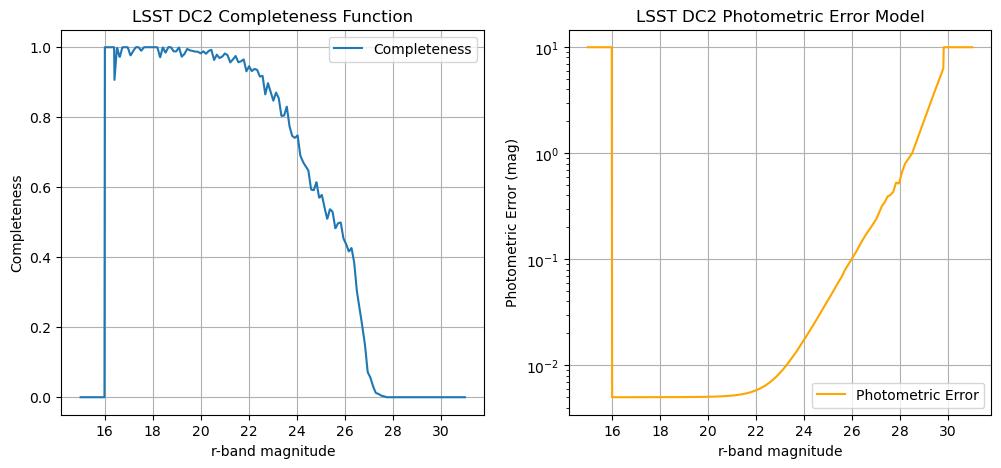

In [4]:
mag_r_test = np.linspace(15,31, 1000)
maglim_r_dc2 = 26.8
completeness_val = lsst_dc2.get_completeness('r', mag_r_test, maglim_r_dc2)
mag_error_val = lsst_dc2.get_photo_error('r', mag_r_test, maglim_r_dc2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(mag_r_test, completeness_val, label='Completeness')
ax[0].set_xlabel('r-band magnitude')
ax[0].set_ylabel('Completeness')
ax[0].set_title('LSST DC2 Completeness Function')
ax[0].grid()
ax[0].legend()  

ax[1].plot(mag_r_test, mag_error_val, label='Photometric Error', color='orange')
ax[1].set_yscale('log')
ax[1].set_xlabel('r-band magnitude')
ax[1].set_ylabel('Photometric Error (mag)')
ax[1].set_title('LSST DC2 Photometric Error Model')
ax[1].grid()
ax[1].legend()
plt.show()

In [5]:
stream_injector = observed.StreamInjector(lsst_dc2)

In [6]:
N = 1000
seed = 42

rng = np.random.default_rng(seed)

data_test = pd.DataFrame({
    'phi1': rng.uniform(-5, 5, N),
    'phi2': rng.uniform(-1, 1, N),
    #'ra': rng.random.uniform(-5, 5, N),
    #'dec': rng.random.uniform(-1, 1, N),
    'mag_g': rng.uniform(15, 30, N),
    'mag_r': rng.uniform(15, 30, N),
})



injected_data = stream_injector.inject(data_test, seed=seed, mask_type = ['footprint', 'ebv'], verbose=True)


Building new mask for ['ebv', 'footprint']...
  Resampling ebv from nside=4096 to nside=128
✓ Mask created: valid pixels fraction (0.5%)
  Cached with key: ('lsst', ('ebv', 'footprint'), 0.2)
Found suitable great circle frame after 2 trials with 100.00% points inside the mask.


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying detection cut on g band with SNR >= 5.0


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<Figure size 800x500 with 2 Axes>, <Axes: >)

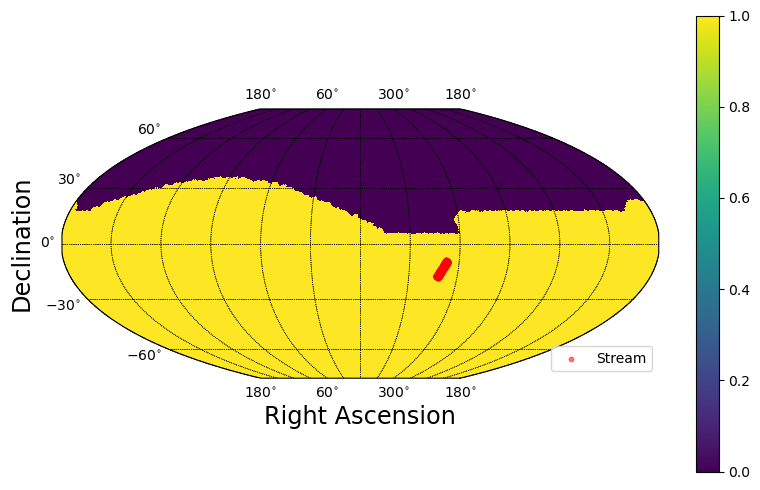

In [7]:
stream_injector.plot_stream_in_mask(injected_data, mask_type='footprint')

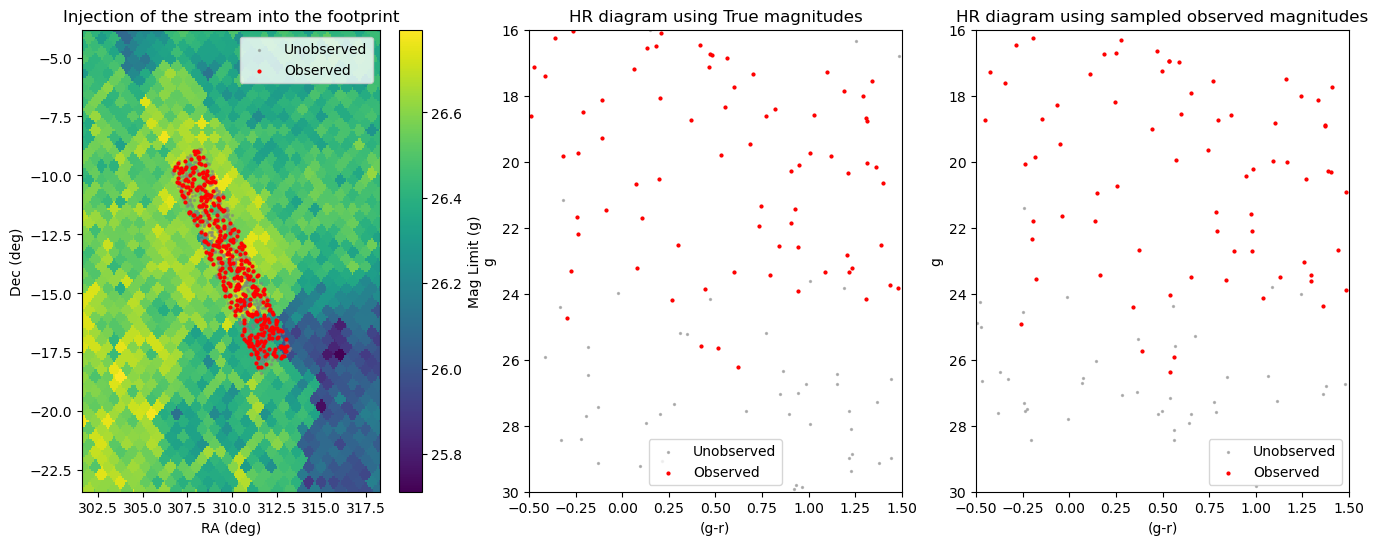

In [8]:

from stream_sim.plotting import plot_inject

# Plot results
fig, ax = plot_inject(injected_data, lsst_dc2, bands=['g', 'r'], save=False)
plt.show()

✓ Using cached survey data for 'lsst_yr5'
✓ Using cached mask for ['ebv', 'footprint']
Found suitable great circle frame after 2 trials with 100.00% points inside the mask.


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying detection cut on g band with SNR >= 5.0


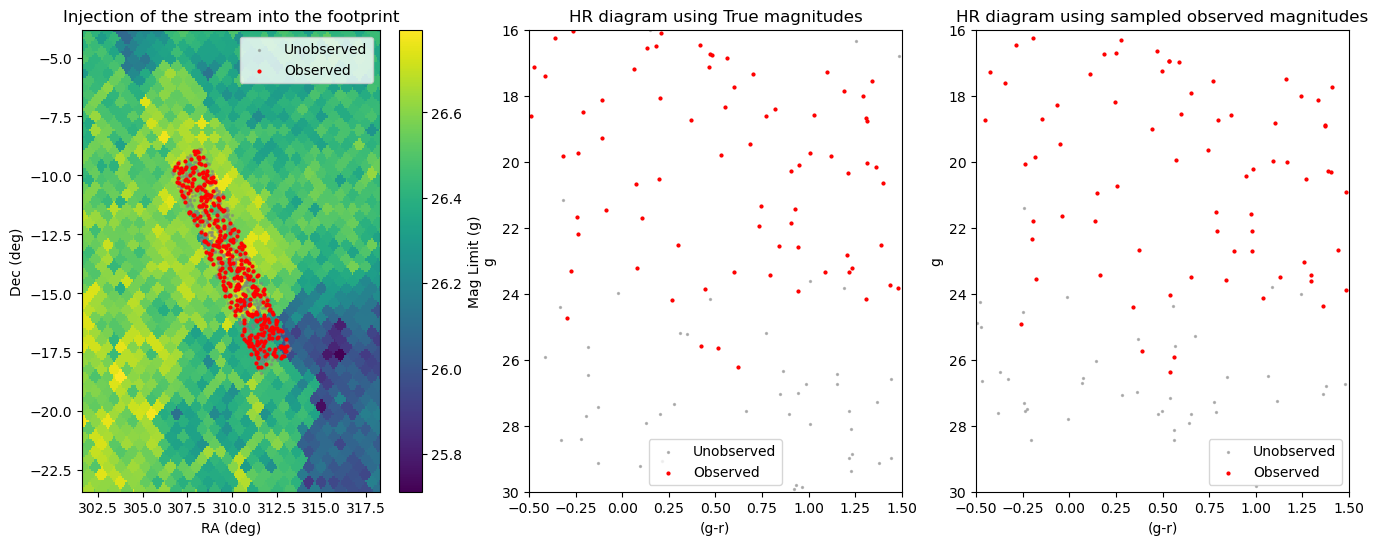

✓ Using cached survey data for 'lsst_yr5'
✓ Using cached mask for ['ebv', 'footprint']
Found suitable great circle frame after 1 trials with 100.00% points inside the mask.


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying detection cut on g band with SNR >= 5.0


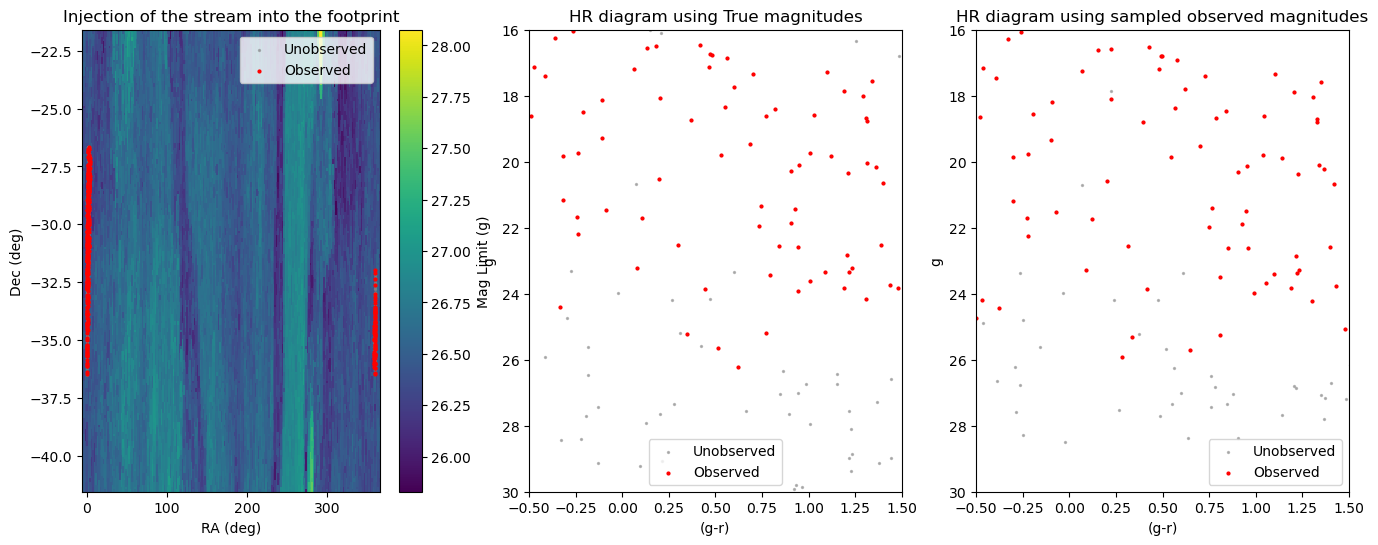

✓ Using cached survey data for 'lsst_yr5'
✓ Using cached mask for ['ebv', 'footprint']
Found suitable great circle frame after 1 trials with 100.00% points inside the mask.


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying detection cut on g band with SNR >= 5.0


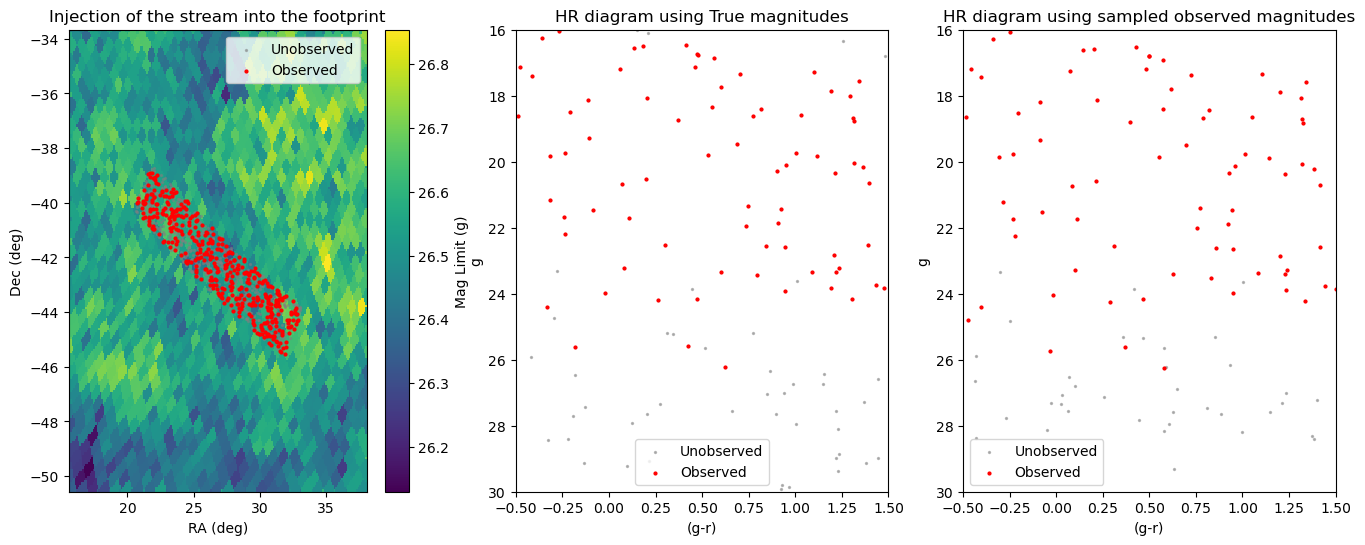

✓ Using cached survey data for 'lsst_yr5'
✓ Using cached mask for ['ebv', 'footprint']
Found suitable great circle frame after 6 trials with 100.00% points inside the mask.


/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/sps/lsst/users/mpelissi/envs/env_miniconda_py13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Applying detection cut on g band with SNR >= 5.0


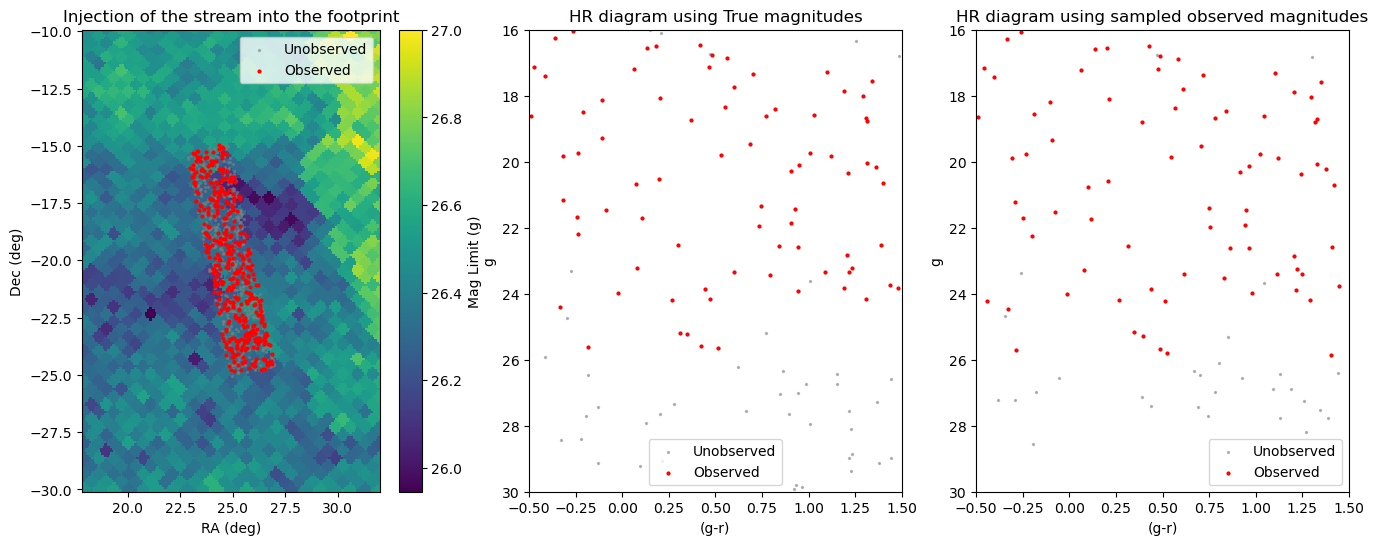

In [11]:
import gc
it = 4

for i in range(it):
    # creat injector
    stream_injector = observed.StreamInjector(survey='lsst', release='yr5')
    # inject
    injected_data = stream_injector.inject(data_test, seed=seed+i, mask_type = ['footprint', 'ebv'], verbose=True)
    # plot
    fig, ax = plot_inject(injected_data, stream_injector.survey, bands=['g', 'r'], save=False)
    plt.show()

    del stream_injector
    gc.collect()